# Analysing WaPOR data

This notebook contains code snippet to analyse WaPOR data
- [1. Calculate the average value of ROI](#1.-Calculate-the-average-value-of-ROI)
- [2. Working with timeseries (pandas library)](#2.-Working-with-timeseries-(pandas-library))
- [3. Raster calculation](#3.-Raster-calculation)
- [4. Land-use analysis](#4.-Land-use-analysis)

### Example
For this exercise, we can make use of the user-defined functions we made in the previous exercise to read can write raster data.

In [2]:
import numpy as np
import gdal
import osr
import os
import matplotlib.pyplot as plt
import pandas as pd

def GetGeoInfo(fh, subdataset = 0):
    """
    Substract metadata from a geotiff, HDF4 or netCDF file.
    
    Parameters
    ----------
    fh : str
        Filehandle to file to be scrutinized.
    subdataset : int, optional
        Layer to be used in case of HDF4 or netCDF format, default is 0.
        
    Returns
    -------
    driver : str
        Driver of the fh.
    NDV : float
        No-data-value of the fh.
    xsize : int
        Amount of pixels in x direction.
    ysize : int
        Amount of pixels in y direction.
    GeoT : list
        List with geotransform values.
    Projection : str
        Projection of fh.
    """
    SourceDS = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = SourceDS.GetDriver().ShortName
    if Type == 'HDF4' or Type == 'netCDF':
        SourceDS = gdal.Open(SourceDS.GetSubDatasets()[subdataset][0])
    NDV = SourceDS.GetRasterBand(1).GetNoDataValue()
    xsize = SourceDS.RasterXSize
    ysize = SourceDS.RasterYSize
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    """
    Open a map as an numpy array. 
    
    Parameters
    ----------
    fh: str
        Filehandle to map to open.
    bandnumber : int, optional 
        Band or layer to open as array, default is 1.
    dtype : str, optional
        Datatype of output array, default is 'float32'.
    nan_values : boolean, optional
        Convert he no-data-values into np.nan values, note that dtype needs to
        be a float if True. Default is False.
        
    Returns
    -------
    Array : ndarray
        Array with the pixel values.
    """
    datatypes = {"uint8": np.uint8, "int8": np.int8, "uint16": np.uint16, "int16":  np.int16, "Int16":  np.int16, "uint32": np.uint32,
    "int32": np.int32, "float32": np.float32, "float64": np.float64, "complex64": np.complex64, "complex128": np.complex128,
    "Int32": np.int32, "Float32": np.float32, "Float64": np.float64, "Complex64": np.complex64, "Complex128": np.complex128,}
    DataSet = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    if Type == 'HDF4':
        Subdataset = gdal.Open(DataSet.GetSubDatasets()[bandnumber][0])
        NDV = int(Subdataset.GetMetadata()['_FillValue'])
    else:
        Subdataset = DataSet.GetRasterBand(bandnumber)
        NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(datatypes[dtype])
    if nan_values:
        Array[Array == NDV] = np.nan
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, Projection, explicit = True, compress = None):
    """
    Creates a geotiff from a numpy array.
    
    Parameters
    ----------
    fh : str
        Filehandle for output.
    Array: ndarray
        Array to convert to geotiff.
    driver : str
        Driver of the fh.
    NDV : float
        No-data-value of the fh.
    xsize : int
        Amount of pixels in x direction.
    ysize : int
        Amount of pixels in y direction.
    GeoT : list
        List with geotransform values.
    Projection : str
        Projection of fh.    
    """
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    if compress != None:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name], ['COMPRESS={0}'.format(compress)])
    else:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name])
    if NDV is None:
        NDV = -9999
    if explicit:
        Array[np.isnan(Array)] = NDV
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet = None
    if "nt" not in Array.dtype.name:
        Array[Array == NDV] = np.nan


def MatchProjResNDV(source_file, target_fhs, output_dir, resample = 'near', dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    Matches the projection, resolution and no-data-value of a list of target-files
    with a source-file and saves the new maps in output_dir.
    
    Parameters
    ----------
    source_file : str
        The file to match the projection, resolution and ndv with.
    target_fhs : list
        The files to be reprojected.
    output_dir : str
        Folder to store the output.
    resample : str, optional
        Resampling method to use, default is 'near' (nearest neighbour).
    dtype : str, optional
        Datatype of output, default is 'float32'.
    scale : int, optional
        Multiple all maps with this value, default is None.
    
    Returns
    -------
    output_files : ndarray 
        Filehandles of the created files.
    """
    dst_info=gdal.Info(gdal.Open(source_file),format='json')
    output_files = np.array([])
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for target_file in target_fhs:
        folder, fn = os.path.split(target_file)
        src_info=gdal.Info(gdal.Open(target_file),format='json')
        output_file = os.path.join(output_dir, fn)
        gdal.Warp(output_file,target_file,format='GTiff',
                      srcSRS=src_info['coordinateSystem']['wkt'],
                      dstSRS=dst_info['coordinateSystem']['wkt'],
                      srcNodata=src_info['bands'][0]['noDataValue'],
                      dstNodata=dst_info['bands'][0]['noDataValue'],
                      width=dst_info['size'][0],
                      height=dst_info['size'][1],
                      outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                                    dst_info['cornerCoordinates']['lowerLeft'][1],
                                    dst_info['cornerCoordinates']['upperRight'][0],
                                    dst_info['cornerCoordinates']['upperRight'][1]),
                      outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
                      resampleAlg=resample)
        output_files = np.append(output_files, output_file)
        if not np.any([scale == 1.0, scale == None, scale == 1]):
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = True) * scale
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
        if ndv_to_zero:
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = False)
            DATA[DATA == NDV] = 0.0
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
    return output_files

## 1. Calculate the average value of ROI
### Example
Calculate average precipitation in a ROI from a raster map (mm/month). First, check if the Precipitation map is warped to the same size with the Land-use map of ROI.

In [2]:
import os 
import glob

LU_fh=r"E:\Exercise\Awash\LUWA\Awash2009.tif"
P_folder=r'E:\Exercise\2.2\Warped\P'
P_fhs=glob.glob(os.path.join(P_folder,'*.tif'))
P_fh=P_fhs[0]
P=OpenRasterAsArray(P_fh)
LU=OpenRasterAsArray(LU_fh)
print(P.shape)
print(LU.shape)

(5001L, 5969L)
(5001L, 5969L)


The Precipitation raster contains all the data in the spatial extent, even outside of the basin boundary (our region of interest).

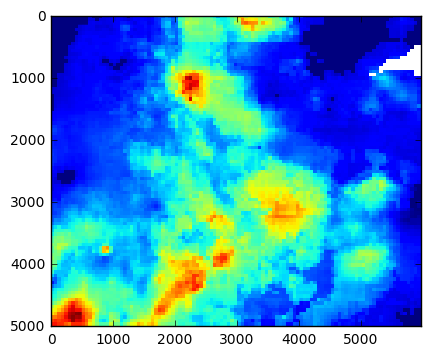

In [3]:
plt.imshow(P)
plt.show()

The Region of Interest is defined by Land-use map. A mask can be created from land-use map using *numpy.where*

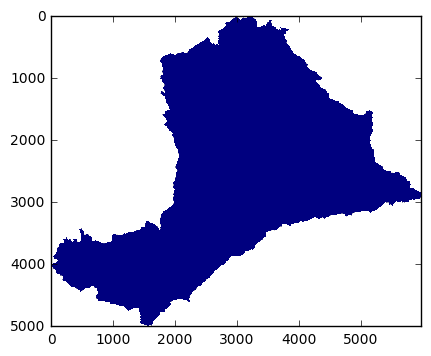

In [4]:
mask=np.where(np.isnan(LU),np.nan,1)
plt.imshow(mask)
plt.show()

By multiplying Precipitaion raster data with the *mask* array, we get only the array with data in our ROI. All the pixels outside of the ROI has nan values (nodata value).

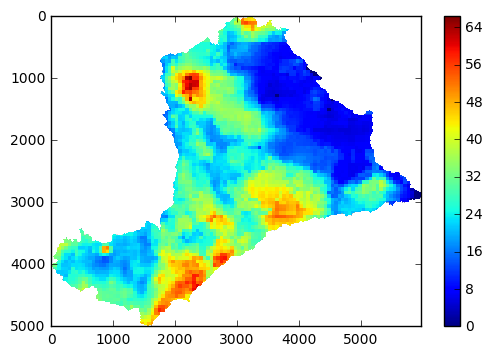

In [5]:
Basin_P=P*mask
plt.imshow(Basin_P)
plt.colorbar()
plt.show()

Thus, we can get the average Precipitation of the whole area by *numpy.nanmean* which means calculate the average excluding pixels with nan values.

In [6]:
Average_P=np.nanmean(Basin_P)
print('Average Precipitation (mm/month): {0}'.format(Average_P))

Average Precipitation (mm/month): 25.6439098263


### Exercise (+)
Get values of all monthly Precipitation maps and save the value in a Python *list* and plot average precipitation against time.

**Hint**: You can make use of the file name to get *datetime* index. Look at example below.

In [7]:
import datetime

P_fh=r"E:\Exercise\2.2\Warped\P\PCP_200901.tif"
filename=os.path.split(P_fh)[-1]    
datestr=filename.split('.')[0].split('_')[-1]
print(datestr)
dyear=int(datestr[0:4])
dmonth=int(datestr[4:6])
datetime.date(dyear,dmonth,1)

200901


datetime.date(2009, 1, 1)

In [ ]:
'''Write your code here'''

In [8]:
LU_fh=r"E:\Exercise\Awash\LUWA\Awash2009.tif"
LU=OpenRasterAsArray(LU_fh)
mask=np.where(np.isnan(LU),np.nan,1)

dates=[]
months=[]
years=[]
P_values=[]
for P_fh in P_fhs:
    filename=os.path.split(P_fh)[-1]    
    datestr=filename.split('.')[0].split('_')[-1]
    dyear=int(datestr[0:4]) #convert string to integer number
    dmonth=int(datestr[4:6])
    dates.append(datetime.date(dyear,dmonth,1))
    months.append(dmonth)
    years.append(dyear)
    #Calculate value
    P=OpenRasterAsArray(P_fh)    
    Basin_P=P*mask
    Average_P=np.nanmean(Basin_P)
    P_values.append(Average_P)

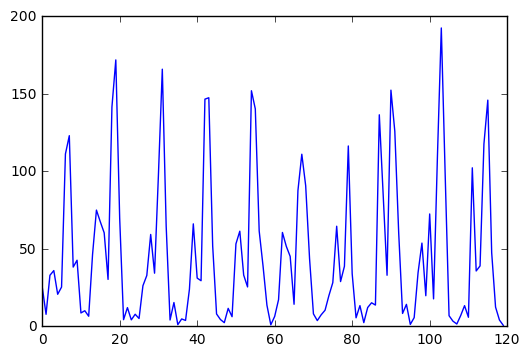

In [9]:
plt.plot(P_values)
plt.show()

We can decorate our graph with some extra code. For example

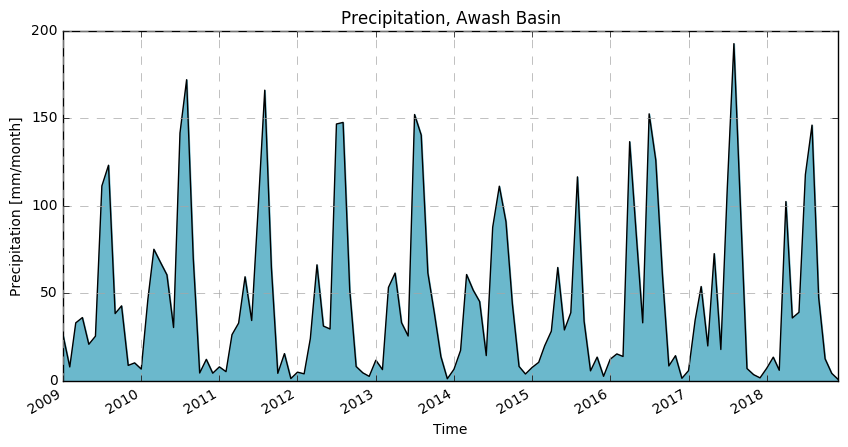

In [10]:
output_dir=r'E:\Exercise\2.2\Plots'
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
plt.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax = plt.subplot(111)
ax.plot(dates, P_values, '-k') #Plot data as line
ax.fill_between(dates, P_values, color = '#6bb8cc') #Fill line area with color
ax.set_xlabel('Time') # X axis title
ax.set_ylabel('Precipitation [mm/month]') #Y axis title
ax.set_title('Precipitation, Awash Basin') #Figure title
fig.autofmt_xdate()
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_ts.png'))
plt.show()
plt.close(fig)

## 2. Working with timeseries (pandas library)
### Example
The lists created (*dates*, *months*, *years*, *P_values*) can be combined in a DataFrame object using *pandas.DataFrame*. This structure makes cleaning, transforming, manipulating and analyzing data easier.

In [12]:
P_df=pd.DataFrame({'date':dates,'month':months,'year':years,'value': P_values})
P_df.head()

,date,month,value,year
0,2009-01-01,1,25.643910,2009
1,2009-02-01,2,7.822536,2009
2,2009-03-01,3,33.018515,2009
3,2009-04-01,4,36.033698,2009
4,2009-05-01,5,20.751515,2009


For example, we can easily sum up precipitation of the monthly values into the yearly total precipitation using *groupby* of column *year* with method *sum*.

In [13]:
Year_total=P_df.groupby(['year']).sum()
Year_total['value']

year
2009    482.887499
2010    690.525775
2011    515.055955
2012    520.744624
2013    599.004085
2014    540.812535
2015    370.520547
2016    658.558589
2017    616.277271
2018    532.151528
Name: value, dtype: float64

DataFrame columns can be converted to array and plotted easily. Below is the code to plot the total yearly precipitation. Discuss the interannual variation of precipitation in Awash.

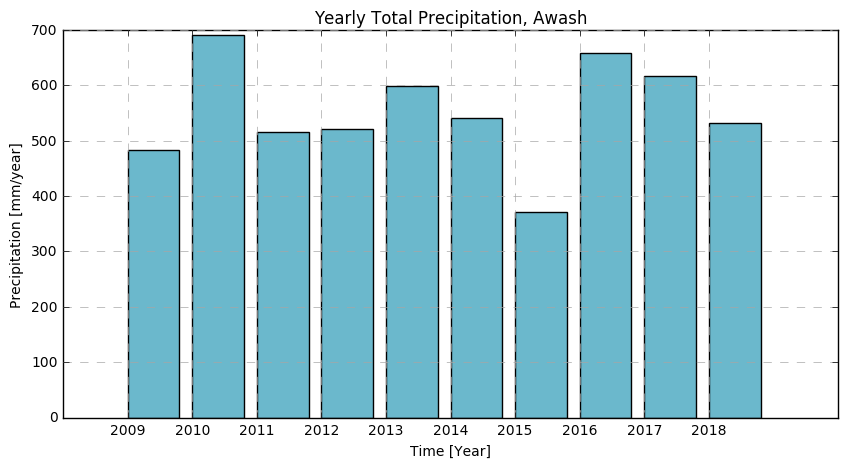

In [14]:
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
ax2 = plt.subplot(111)
ax2.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax2.bar(Year_total.index, Year_total['value'].values, 0.8, color = '#6bb8cc')
ax2.set_xlabel('Time [Year]')
ax2.set_xticks(Year_total.index)
ax2.set_ylabel('Precipitation [mm/year]')
ax2.set_title('Yearly Total Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_year.png'))
plt.show()
plt.close(fig)

### Exercise (+)
Calculate and plot the mean Precipitation of the calendar months. Discuss precipitation distribution in an average year.

**Hint**
Instead of using method *sum* in *groupby*, use *mean* 

In [ ]:
'''Write your code here'''

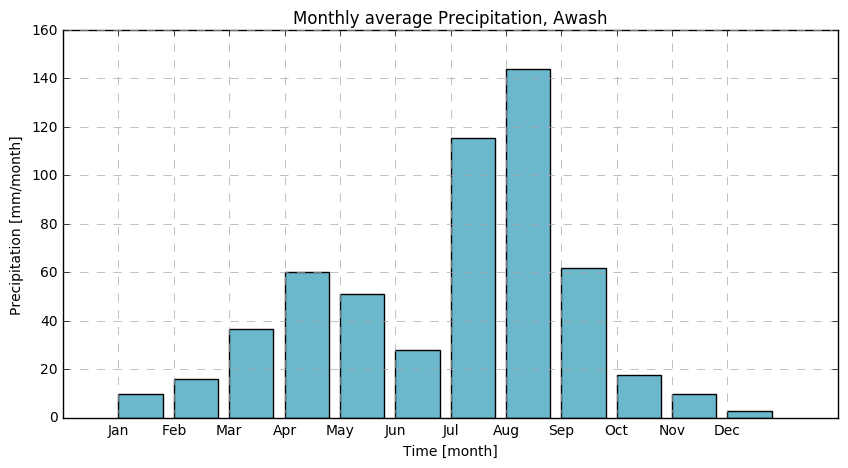

In [15]:
Month_avg=P_df.groupby(['month']).mean()
Month_avg['value']
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
#subplot 1
ax1 = plt.subplot(111)
ax1.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax1.bar(Month_avg.index, Month_avg['value'].values, 0.8, color = '#6bb8cc')
ax1.set_xlabel('Time [month]')
monthname={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
monthslabel=monthname.values()
ax1.set_xticks(Month_avg.index)
ax1.set_xticklabels(monthslabel)
ax1.set_ylabel('Precipitation [mm/month]')
ax1.set_title('Monthly average Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_month.png'))
plt.show()
plt.close(fig)

We can also save our dataframe as csv file using pandas.DataFrame method *to_csv* for later use in other analysis. 

In [16]:
Month_max=P_df.groupby(['month']).max()
Month_min=P_df.groupby(['month']).min()
Month_med=P_df.groupby(['month']).median()
Month_std=P_df.groupby(['month']).std()

Month_stat=pd.DataFrame({'month': Month_avg.index,'Mean':Month_avg['value'].values,
                        'Max':Month_max['value'].values, 'Min':Month_min['value'].values,
                        'Median':Month_med['value'].values,'Std':Month_std['value'].values})
print(Month_stat)
Month_stat.to_csv(r'E:\Exercise\2.2\P_month_stats.csv',sep=';')

           Max        Mean      Median         Min        Std  month
0    25.643910    9.551347    7.260567    4.842499   6.139329      1
1    46.453996   16.063623   11.933979    3.878622  13.908367      2
2    75.069160   36.573461   29.644979    5.911596  22.722207      3
3   136.544770   60.274347   56.563956   19.816377  36.129149      4
4    84.845797   50.788983   52.266176   20.751515  20.675400      5
5    39.045492   27.821241   29.224390   14.305187   7.460188      6
6   152.444191  115.567897  114.496883   38.825547  35.551270      7
7   192.565807  144.093199  143.174255  111.104820  26.371731      8
8    97.792709   61.705076   61.075026   33.973936  20.647026      9
9    43.789278   17.540237    8.224638    4.167911  16.955271     10
10   15.429005    9.784298   10.420884    3.422165   4.598692     11
11   10.140760    2.890132    2.010686    0.689605   2.807199     12


## 3. Raster calculation
### Example: P - ET
First, we need to get the file handler of the rasters of the same date that have been matched projection, size and resolution. We can make use of the time format in file name as below.

In [17]:
start_date='2009-01-01'
end_date='2009-12-31'
dates=pd.date_range(start_date,end_date,freq='M')
P_path=r'E:\Exercise\2.2\Warped\P\PCP_{:04d}{:02d}.tif'
ET_path=r'E:\Exercise\2.2\Warped\ET\AETI_{:04d}{:02d}.tif'

date=dates[0]
print(date)
P_fh=P_path.format(date.year,date.month)
ET_fh=ET_path.format(date.year,date.month)
print(P_fh)
print(ET_fh)

2009-01-31 00:00:00
E:\Exercise\2.2\Warped\P\PCP_200901.tif
E:\Exercise\2.2\Warped\ET\AETI_200901.tif


The difference between Precipitation and Total EvapoTranspiration (P-ET) of the pixel can indicate whether the pixel is sink or source of water. When P-ET>0, water is generated in the pixel area. When P-ET< 0, water is more depleted in the pixel area. For example, below is how we can calculate P-ET for one month (January 2009). Notice where P-ET is negative and positive.

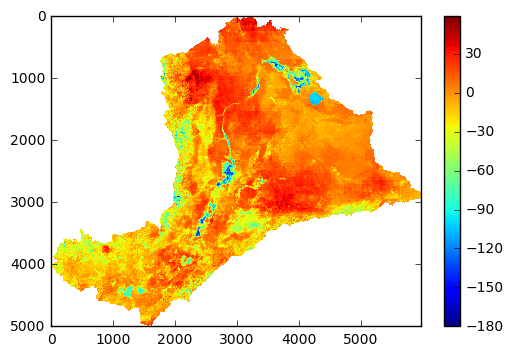

In [18]:
P=OpenRasterAsArray(P_fh)
ET=OpenRasterAsArray(ET_fh)
P_ET=P-ET
plt.imshow(P_ET)
plt.colorbar()
plt.show()

### Exercise (++) 
Calculate annual P - ET of a chosen year in Awash Basin. Discuss the source (P-ET > 0) and sink (P-ET < 0) of water and compare your year result with others.

**Hint**: You can calculate total annual map of P and ET from monthly maps then substract annual ET from annual P map or calculate difference each month then sum up. 
Questions:
- Would the two method give same results? Why?
- Which method is faster? Why?

In [ ]:
'''Write your code here'''

## 4. Land-use analysis
### Example:
Get value per a land-use class (Water bodies).

In [19]:
LU_fh=r"E:\Exercise\Awash\LUWA\Awash2009.tif"
in_fh=r"E:\Exercise\2.2\Warped\ET\AETI_200901.tif"

LU=OpenRasterAsArray(LU_fh)
LU_values=np.unique(LU[~np.isnan(LU)])
LU_codes=list(LU_values)
print(LU_codes)

[1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 14.0, 16.0, 24.0, 27.0, 30.0, 35.0, 36.0, 37.0, 39.0, 40.0, 41.0, 43.0, 57.0, 72.0]


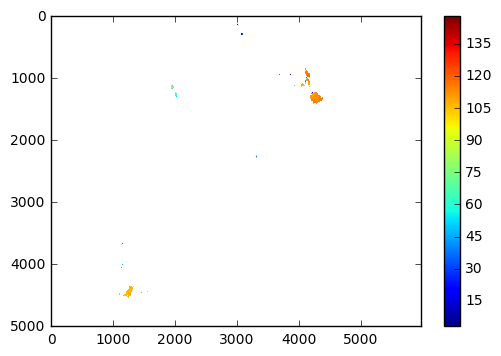

In [20]:
code=24 #Natural lake

mask=np.where(LU==code,0,1)
var=OpenRasterAsArray(in_fh)

import numpy.ma as ma
masked_map=ma.masked_array(var,mask)
plt.imshow(masked_map)
plt.colorbar()
plt.show()

In [21]:
average=np.nanmean(masked_map)
print('Landuse class {0} Average: {1}'.format(code,average))

Landuse class 24 Average: 101.971382141


### Exercise (++)
Calculate a table of annual average ET, E,T, I and P-ET of all land-use class. 
Discuss which land-use class is sink and which is source. 
Compare Evaporation in the main classes: Forest, Shrubland, Grassland, Water bodies, Bare land, Rainfed crops, Irrigated crops.

**Hints**: You can use a for-loop over all land-use classes in the land-use map.

In [ ]:
'''Write your code here'''

In [22]:
averages=[]
for code in LU_codes:
    mask=np.where(LU==code,0,1)
    masked_map=ma.masked_array(var,mask)
    averages.append(np.nanmean(masked_map))
LU_avg=pd.DataFrame({'LU code':LU_codes,'Average Value': averages})
LU_avg

,Average Value,LU code
0,68.350388,1.0
1,48.799568,2.0
2,52.558819,3.0
3,94.728249,4.0
4,58.646912,5.0
5,15.842953,7.0
6,55.267586,10.0
7,36.690361,14.0
8,42.118450,16.0
9,101.971382,24.0
